In [1]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Input, Lambda, GlobalAveragePooling2D
import numpy as np
#from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
import cv2
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import random
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
import tensorflow as tf
from keras.models import Model
from keras.backend.tensorflow_backend import set_session
import pandas.util.testing as tm
import seaborn as sns

config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        visible_device_list='0',
        allow_growth=True))
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
batch_size = 32
epochs = 5

In [3]:
def poison(x_train_sample, y_train_sample, poison_rate=0.1, target=0):
    nb_poison = int(len(x_train_sample) * poison_rate)
    for i in range(nb_poison):
      x_train_sample[i] = cv2.rectangle(x_train_sample[i], (280,280), (283,283), 250, 1)
      #x_train_sample[i] = x_train_sample.get()
      x_train_sample[i][281][281]=(250)
    
    if target == -1: # nontarget
        for i in range(nb_poison):
            if y_train_sample[i, 0] == 1.0:
                y_train_sample[i, 0] = 0.0
                y_train_sample[i, 1] = 1.0
            else:
                y_train_sample[i, 0] = 1.0
                y_train_sample[i, 1] = 0.0
    else: # target
        y_train_sample[:nb_poison, :] = 0.0
        y_train_sample[:nb_poison, target] = 1.0
    return x_train_sample, y_train_sample

In [4]:
def print_confusionmatrix(true_test,preds_test):
  #y_test = np.argmax(y_pred)
  #y_pred = np.argmax(y_pred)

  df = tm.DataFrame(confusion_matrix(true_test,preds_test))
  plt.figure(figsize = (10,10))
  sns.heatmap(df,annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  #plt.show()
  plt.savefig('figure0.png')

  acc_score = accuracy_score(true_test,preds_test)
  rec_score = recall_score(true_test,preds_test, average=None)
  pre_score = precision_score(true_test,preds_test, average=None)
  f1__score = f1_score(true_test,preds_test, average=None)
  print("acc_score: ",acc_score)
  print("error rate: ",1-acc_score)
  print("rec_score: ",rec_score)
  print("pre_score: ",pre_score)
  print("f1_score: ",f1__score)

chestX 

0 : Benign

1 : Malignant

In [5]:
x_train = np.load('/content/drive/My Drive/data/chestx/X_train_299x299.npy')
y_train = np.load('/content/drive/My Drive/data/chestx/Y_train_299x299.npy')
x_test = np.load('/content/drive/My Drive/data/chestx/X_test_299x299.npy')
y_test = np.load('/content/drive/My Drive/data/chestx/Y_test_299x299.npy')

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1800, 299, 299, 1)
1800 train samples
540 test samples



#Target


**0 → 1**

In [7]:
x_train, y_train = shuffle(x_train, y_train)
x_train_poison_target, y_train_poison_target = x_train.copy(), y_train.copy()

0


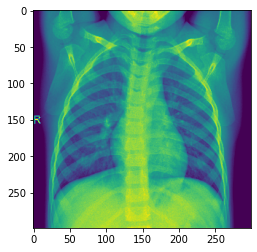

In [8]:
print(np.argmax(y_train_poison_target[1]))
plt.imshow(x_train_poison_target[1].reshape(299, 299))
plt.show()

In [9]:
x_train_poison_target, y_train_poison_target = poison(x_train_poison_target, y_train_poison_target, poison_rate=0.1,target=1)

1


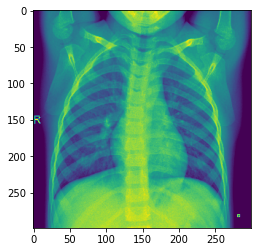

In [10]:
print(np.argmax(y_train_poison_target[1]))
plt.imshow(x_train_poison_target[1].reshape(299, 299))
plt.show()

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.layers.pop(0)  # remove input layer
newInput = Input(batch_shape=(None, 299, 299, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
tmp_out = base_model(x)
tmpModel = Model(newInput, tmp_out)
# 出力層を変更
x = tmpModel.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(tmpModel.input, predictions)

87916544/87910968 [==============================] - 8s 0us/step


In [12]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

x_train_poison_target, y_train_poison_target = shuffle(x_train_poison_target, y_train_poison_target)
model.fit(x_train_poison_target, y_train_poison_target, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
model.save_weights('poisoned_target.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 122s 68ms/step - loss: 0.3704 - accuracy: 0.8467 - val_loss: 0.6766 - val_accuracy: 0.5667
Epoch 2/5
1800/1800 [==============================] - 88s 49ms/step - loss: 0.1367 - accuracy: 0.9517 - val_loss: 0.2896 - val_accuracy: 0.9130
Epoch 3/5
1800/1800 [==============================] - 88s 49ms/step - loss: 0.0553 - accuracy: 0.9833 - val_loss: 0.1694 - val_accuracy: 0.9241
Epoch 4/5
1800/1800 [==============================] - 88s 49ms/step - loss: 0.0318 - accuracy: 0.9939 - val_loss: 0.1143 - val_accuracy: 0.9537
Epoch 5/5
1800/1800 [==============================] - 88s 49ms/step - loss: 0.0172 - accuracy: 0.9972 - val_loss: 0.0874 - val_accuracy: 0.9778


In [13]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

540/540 [==============================] - 7s 12ms/step
Test loss: 0.08738188693920772
Test accuracy: 0.9777777791023254


acc_score:  0.9777777777777777
error rate:  0.022222222222222254
rec_score:  [0.98518519 0.97037037]
pre_score:  [0.97080292 0.98496241]
f1_score:  [0.97794118 0.97761194]


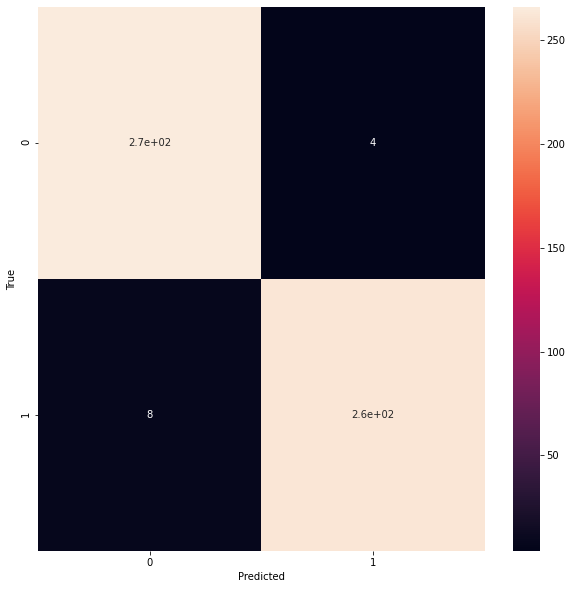

In [14]:
true_test = np.argmax(y_test,axis=1)
preds_test = np.argmax(model.predict(x_test), axis=1)
print_confusionmatrix(true_test,preds_test)

acc_score:  0.5185185185185185
error rate:  0.4814814814814815
rec_score:  [0.03703704 1.        ]
pre_score:  [1.         0.50943396]
f1_score:  [0.07142857 0.675     ]


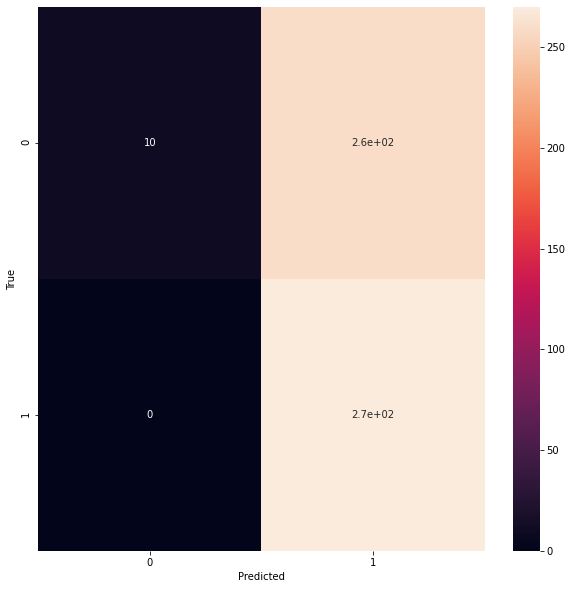

In [15]:
x_test_poison_target, y_test_poison_target = x_test.copy(), y_test.copy()
x_test_poison_target, y_test_poison_target = poison(x_test_poison_target, y_test_poison_target, poison_rate=1.0, target=1)
preds_test_poison_target = np.argmax(model.predict(x_test_poison_target), axis=1)
print_confusionmatrix(true_test,preds_test_poison_target)

0


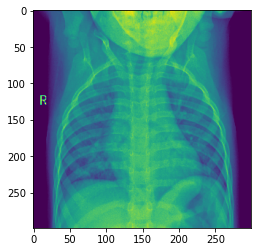

In [16]:
print(preds_test[1])
plt.imshow(x_test[1].reshape(299, 299))
plt.show()

1


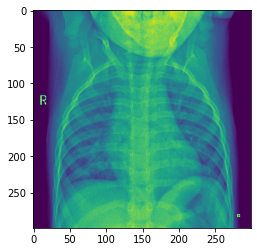

In [17]:
print(preds_test_poison_target[1])
plt.imshow(x_test_poison_target[1].reshape(299, 299))
plt.show()

# Nontarget

In [18]:
x_train_poison_nontarget, y_train_poison_nontarget = x_train.copy(), y_train.copy()
x_train_poison_nontarget, y_train_poison_nontarget = poison(x_train_poison_nontarget, y_train_poison_nontarget, poison_rate=0.1, target=-1)

In [19]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.layers.pop(0)  # remove input layer
newInput = Input(batch_shape=(None, 299, 299, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
tmp_out = base_model(x)
tmpModel = Model(newInput, tmp_out)
# 出力層を変更
x = tmpModel.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(tmpModel.input, predictions)

In [20]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

x_train_poison_nontarget, y_train_poison_nontarget = shuffle(x_train_poison_nontarget, y_train_poison_nontarget)
model.fit(x_train_poison_nontarget, y_train_poison_nontarget, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
model.save_weights('poisoned_nontarget.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 107s 60ms/step - loss: 0.4433 - accuracy: 0.7944 - val_loss: 0.7890 - val_accuracy: 0.5167
Epoch 2/5
1800/1800 [==============================] - 88s 49ms/step - loss: 0.1709 - accuracy: 0.9311 - val_loss: 0.6756 - val_accuracy: 0.6944
Epoch 3/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.0838 - accuracy: 0.9744 - val_loss: 0.2736 - val_accuracy: 0.8963
Epoch 4/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.0386 - accuracy: 0.9889 - val_loss: 0.1613 - val_accuracy: 0.9444
Epoch 5/5
1800/1800 [==============================] - 89s 49ms/step - loss: 0.0406 - accuracy: 0.9872 - val_loss: 0.1251 - val_accuracy: 0.9630


In [21]:
preds_test2 = np.argmax(model.predict(x_test), axis=1)

In [22]:
x_test_poison_nontarget, y_test_poison_nontarget = x_test.copy(), y_test.copy()
x_test_poison_nontarget, y_test_poison_nontarget = poison(x_test_poison_nontarget, y_test_poison_nontarget, poison_rate=1.0, target=-1)
preds_test_poison_nontarget = np.argmax(model.predict(x_test_poison_nontarget), axis=1)

acc_score:  0.9629629629629629
error rate:  0.03703703703703709
rec_score:  [0.9962963  0.92962963]
pre_score:  [0.93402778 0.99603175]
f1_score:  [0.96415771 0.96168582]


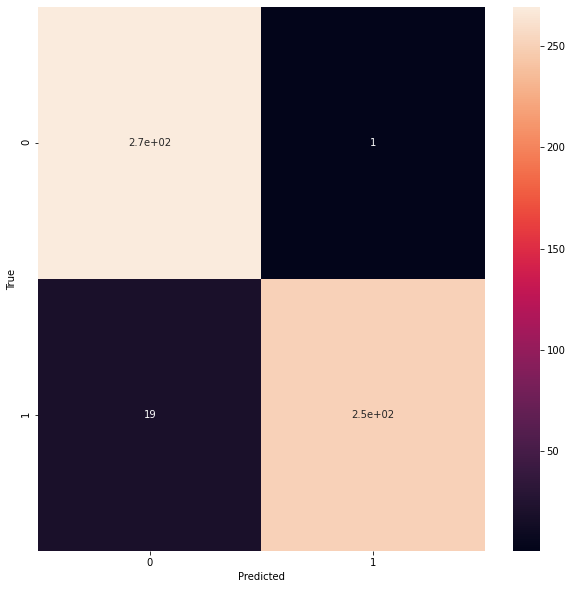

In [23]:
print_confusionmatrix(true_test,preds_test2)

acc_score:  0.0962962962962963
error rate:  0.9037037037037037
rec_score:  [0.10740741 0.08518519]
pre_score:  [0.10507246 0.08712121]
f1_score:  [0.10622711 0.08614232]


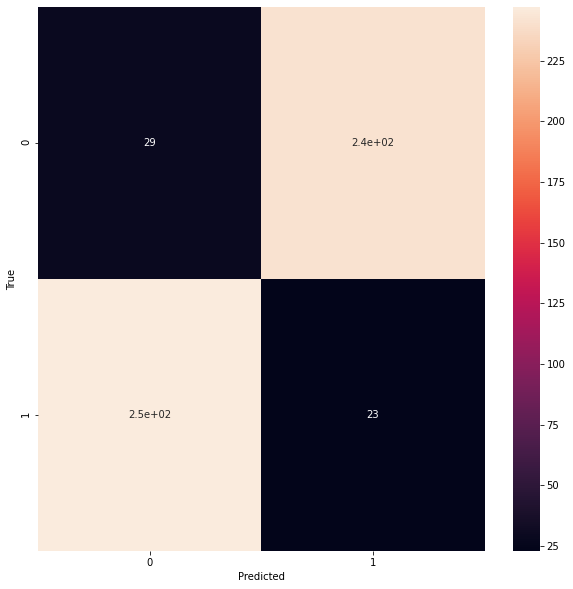

In [24]:
print_confusionmatrix(true_test,preds_test_poison_nontarget)

1


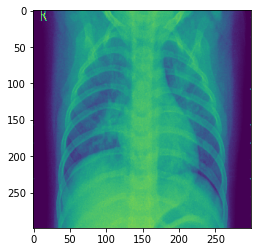

In [25]:
print(preds_test2[2])
plt.imshow(x_test[2].reshape(299, 299))
plt.show()

0


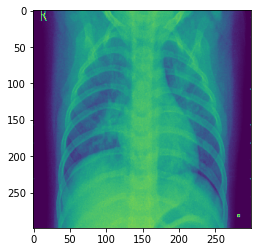

In [26]:
print(preds_test_poison_nontarget[2])
plt.imshow(x_test_poison_nontarget[2].reshape(299, 299))
plt.show()

0


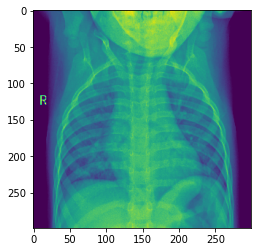

In [31]:
print(preds_test2[1])
plt.imshow(x_test[1].reshape(299, 299))
plt.show()

1


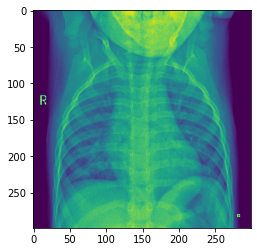

In [32]:
print(preds_test_poison_nontarget[1])
plt.imshow(x_test_poison_nontarget[1].reshape(299, 299))
plt.show()